In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
import visualizations_utils as viz_utils
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint

import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (IrisOptionsRationalSpace, 
                                           IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from visprm import VPRMSeeding

# Build and set up the visualization the plant and the visualization of the C-space obstacle

Note that running this cell multiple times will establish multiple meshcat instances which can fill up your memory. It is a good idea to call "pkill -f meshcat" from the command line before re-running this cell

In [4]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
oneDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf")
twoDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/twoDOF_iiwa7_with_box_collision.sdf")

box_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/box_small.urdf")

models = []
models.append(parser.AddModelFromFile(box_asset))
models.append(parser.AddModelFromFile(twoDOF_iiwa_asset))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset))



locs = [[0.,0.,0.],
        [0.,.55,0.],
        [0.,-.55,0.]]
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("base", models[0]),
                 RigidTransform(locs[0]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_twoDOF_link_0", models[1]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[1]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[2]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[2]))


plant.Finalize()

idx = 0
q0 = [0.0, 0.0, 0.0]
q_low  = [-1.7, -2., -1.7]
q_high = [ 1.7,  2.,  1.7]
# set the joint limits of the plant
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
            idx += 1
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(3)

#compute limits in t-space
limits_t = []
for q in [q_low, q_high]:
    limits_t.append(Ratfk.ComputeTValue(np.array(q), q_star))

do_viz = True

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, viz_role=Role.kIllustration)
diagram = visualizer.diagram

# This line will run marching cubes to generate a mesh of the C-space obstacle
# Increase N to increase the resolution of the C-space obstacle.
visualizer.visualize_collision_constraint(N = 60)

INFO:drake:Meshcat listening for connections at http://localhost:7001
INFO:drake:Meshcat listening for connections at http://localhost:7002
/home/peter/git/vprmintegration/drake/C_Iris_Examples/iris_plant_visualizer.py:31: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  self.vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, self.meshcat1)


# Set up the sliders so we can move the plant around manually


In [5]:
sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))
sliders.append(widgets.FloatSlider(min=q_low[2], max=q_high[2], value=0, description='q2'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.showres(q)
    visualizer.visualize_planes()
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=2.0, min=-2.0)

FloatSlider(value=0.0, description='q2', max=1.7, min=-1.7)

In [6]:
# filter fused joints self collisions so they don't interfere with collision engine
digaram = visualizer.diagram
context = visualizer.diagram_context
sg_context = scene_graph.GetMyContextFromRoot(context)
inspector = scene_graph.model_inspector()

pairs = scene_graph.get_query_output_port().Eval(sg_context).inspector().GetCollisionCandidates()

gids = [gid for gid in inspector.GetGeometryIds(GeometrySet(inspector.GetAllGeometryIds()), Role.kProximity)]
get_name_of_gid = lambda gid : inspector.GetName(gid)
gids.sort(key=get_name_of_gid)
iiwa_oneDOF_gids = [gid for gid in gids if "iiwa7_oneDOF::" in get_name_of_gid(gid)]
iiwa_twoDOF_gids = [gid for gid in gids if "iiwa7_twoDOF::" in get_name_of_gid(gid)]

oneDOF_fused_col_geom = iiwa_oneDOF_gids[2:]
iiwa_oneDOF_fused_set = GeometrySet(oneDOF_fused_col_geom)
twoDOF_fused_col_geom = iiwa_twoDOF_gids[4:]
iiwa_twoDOF_fused_set = GeometrySet(twoDOF_fused_col_geom)
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_oneDOF_fused_set))
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_twoDOF_fused_set))

In [7]:
# Some examples of some seed points which give large regions using the
# non-linear programming approach to IRIS described in Algorithm 3
seed1 = np.array([ 1.6, -0.4, -1.3])
seed2 = np.array([ 0.9, -0.9, -1.7])
poi = np.array([seed1, seed2])
poi_t = np.array([Ratfk.ComputeTValue(poi[idx], np.zeros((3,)))\
                        for idx in range(poi.shape[0])])
if do_viz:
    visualizer.plot_seedpoints(poi_t)

# Setup SNOPT IRIS

In [8]:
#regions = []
#ellipses = []

domain = HPolyhedron.MakeBox( Ratfk.ComputeTValue(q_low, np.zeros((3,))), Ratfk.ComputeTValue(q_high, np.zeros((3,))))
snopt_iris_options = IrisOptionsRationalSpace()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 20
snopt_iris_options.configuration_space_margin = 1e-5
snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.relative_termination_threshold = 0.05
snopt_iris_options.enable_ibex = False

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, iris_options, default_domain):
    #print('snopt iris call')
    if regions is not None:
#         obstacles = []
#         for r in regions:
#             offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
#             rnew = HPolyhedron(r.A(), r.b()-offset)
#             obstacles.append(rnew)
#         try:
#             t_seed = Ratfk.ComputeTValue(q_seed, np.zeros((3,)))
#             domain = Iris(obstacles, t_seed, default_domain, iris_options)
#             print("[SNOPTIRIS] Domain succefully restricted")
#         except:
#             print("[SNOPTIRIS] Domain restriction failed")
        domain = default_domain
    else:
        domain = default_domain
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), snoptiris_options, domain)
    return r

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
                            iris_options = iris_options,
                            default_domain = domain)

# Construct vis checker (here still sample based)

In [9]:
def vis(q1, q2, num_checks, visualizer):
    q1flat = q1.reshape(-1)
    q2flat = q2.reshape(-1)
    if np.linalg.norm(q1-q2) < 1e-6:
        return [(1-visualizer.col_func_handle(q1))>0, None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        q = q1flat*t + (1-t)*q2flat
        if visualizer.col_func_handle(q):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40, visualizer = visualizer)

# Run Seeding Setup and Guard Phase


In [10]:
np.random.seed(11)
vs = VPRMSeeding(poi,
                 alpha = 0.1,
                 limits = [np.array(q_low), np.array(q_high)],
                 collision_handle = visualizer.col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 )

vs.set_guard_regions()

[VPRMSeeding] GuardInsertion attempts M: 44
[VPRMSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


In [11]:
vs.guard_phase()

1
[VPRMSeeding] New guard placed N =  2
[VPRMSeeding] Sample set size 1


# Plot Results after Guard Phase

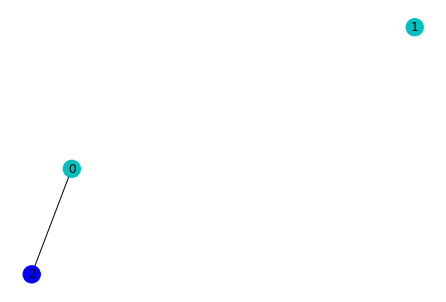

In [12]:
vs.draw_connectivity_graph()
from pydrake.all import Rgba
samples_t = np.array([Ratfk.ComputeTValue( vs.samples_outside_regions[q_s][0], np.zeros(3)) for q_s in vs.samples_outside_regions.keys()])
seeds_t = np.array([Ratfk.ComputeTValue( p, np.zeros(3)) for p in vs.seed_points])

vis_seed = [[seeds_t[vs.regions.index(k)] for k in vis2[1]] for vis2 in vs.samples_outside_regions.values()]
visualizer.plot_points(seeds_t, size = 0.06, color = Rgba(1., 0.0, 1.0, 0.6), start_idx = 0, prefix = 'seed')
visualizer.plot_points(samples_t, size = 0.02, color = Rgba(0., 0.1, 0.0, 0.3), start_idx = len(seeds_t), prefix = 'sample')
visualizer.plot_regions(vs.regions,
                        ellipses= None,#[r.MaximumVolumeInscribedEllipsoid() for r in vs.regions],
                        region_suffix='_guard')

# Connectivity Phase


In [13]:
vs.connectivity_phase()

[VPRMSeeding] Num connected Components Vis: 2
[VPRMSeeding] New region added
[VPRMSeeding] Sample set size 43 num keys to del  1


True

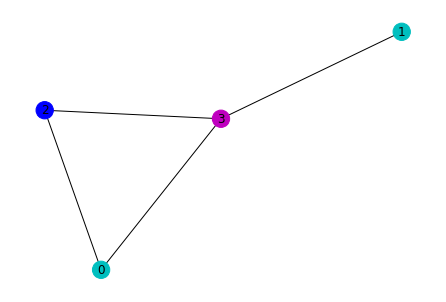

In [14]:
visualizer.plot_regions(vs.regions[len(vs.guard_regions):],
                        ellipses=None, #[r.MaximumVolumeInscribedEllipsoid() for r in vs.regions[len(vs.guard_regions):]],
                        region_suffix='_connectivity', colors=[(255,0,255) for i in range(len(vs.guard_regions))])
vs.draw_connectivity_graph()

# Experiments with default iris

In [23]:
regions = vs.regions[:-1]
obstacles = []
q_seed = np.array([-0.51034035, -0.25427137, -0.65290974])
for r in regions:
    offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
    rnew = HPolyhedron(r.A(), r.b()-offset)
    obstacles.append(rnew)
try:
    t_seed = Ratfk.ComputeTValue(q_seed, np.zeros((3,)))
    domain_new = Iris(obstacles, t_seed, domain, iris_options)
    print("[SNOPTIRIS] Domain succefully restricted")
except:
    print("[SNOPTIRIS] Domain restriction failed")
    domain = default_domain

[SNOPTIRIS] Domain succefully restricted


In [24]:
domain_new

In [28]:
visualizer.plot_regions([domain_new],
                        ellipses=None,
                        region_suffix='_IRISstand', colors=[(255,255,0)])

visualizer.plot_regions([domain],
                        ellipses=None,
                        region_suffix='_IRISstand2', colors=[(255,0,255)])
visualizer.plot_regions(obstacles,
                        ellipses=None,
                        region_suffix='_obstacles', colors=[(0,255,0)]*len(obstacles))